In [2]:
from tqdm import tqdm
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from random import randint
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
import time
from scipy.ndimage.measurements import label
%matplotlib inline

Sample size vehicles:  8792
Sample size non-vehicles:  8968
Image size:  (64, 64, 3)
Data type with plt:  float32
Min:  0.0 Max:  1.0
Data type with cv2:  uint8
Min:  0 Max:  255
Data type with mpimg:  float32
Min:  0.0 Max:  1.0


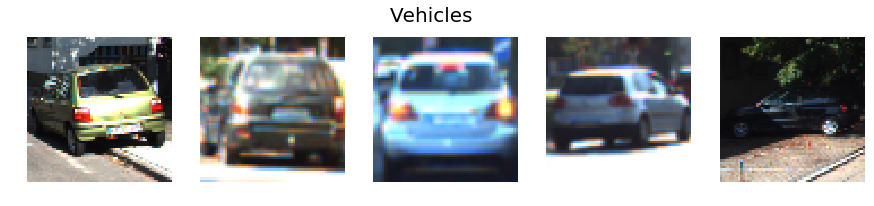

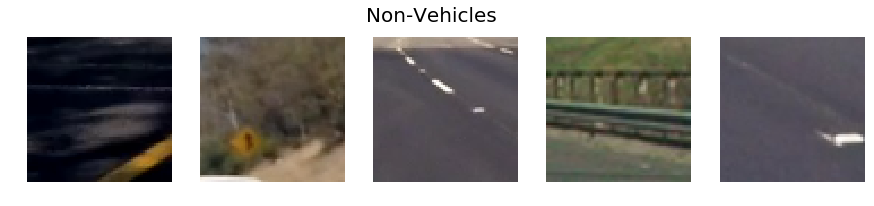

In [5]:
### Explore dataset

## Load images for classifier
images_vehicle = glob.glob('./classifier_images/vehicles/*/*.png')
print ('Sample size vehicles: ', len(images_vehicle))
images_non_vehicle = glob.glob('./classifier_images/non-vehicles/*/*.png')
print ('Sample size non-vehicles: ', len(images_non_vehicle))
print ('Image size: ', plt.imread(images_vehicle[0]).shape)
img_plt = plt.imread(images_vehicle[5])
img_cv2 = cv2.imread(images_vehicle[5])
img_mpimg = mpimg.imread(images_vehicle[5])
print ('Data type with plt: ', img_plt.dtype)
print ('Min: ', np.min(img_plt), 'Max: ', np.max(img_plt))
print ('Data type with cv2: ', img_cv2.dtype)
print ('Min: ', np.min(img_cv2), 'Max: ', np.max(img_cv2))
print ('Data type with mpimg: ', img_mpimg.dtype)
print ('Min: ', np.min(img_mpimg), 'Max: ', np.max(img_mpimg))


## Visualize dataset

# Create list for test images which are used later
test_images = []

# Load and show vehicle images
plt.figure(0, figsize=(15,3))
plt.suptitle('Vehicles', fontsize=20)
for i in range(5):
    rand = randint(0,len(images_vehicle)-1)
    img_vcl = plt.imread(images_vehicle[rand])
    test_images.append(img_vcl)
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(img_vcl)
plt.savefig('./output_images/vehicle_images.png', bbox_inches='tight')

# Load and show non-vehicle images
plt.figure(1, figsize=(15,3))
plt.suptitle('Non-Vehicles', fontsize=20)
for i in range(5):
    rand = randint(0,len(images_non_vehicle)-1)
    img_nvcl = plt.imread(images_non_vehicle[rand])
    test_images.append(img_nvcl)
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(img_nvcl)
plt.savefig('./output_images/non_vehicle_images.png', bbox_inches='tight')
    
plt.show()

In [6]:
### Feature extraction functions

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=128, bins_range=(0, 1), feature_vector=True):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    if (feature_vector==True):
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    else:
        return (channel1_hist[0], channel2_hist[0], channel3_hist[0])

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features    

    
def get_feature(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, color_bins=64):
    # Read in each one by one
    #print ('Before Color_conversion: ', image.dtype)
    #print ('Min: ', np.min(image), 'Max: ', np.max(image))
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Spatial binning
    #bin_features = bin_spatial(image)

    # Get color histogram
    hist_features = color_hist(feature_image, nbins=color_bins, feature_vector=False)
    
    # Get Hog features
    hog_features1 = get_hog_features(feature_image[:,:,0], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    hog_features2= get_hog_features(feature_image[:,:,1], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    hog_features3 = get_hog_features(feature_image[:,:,2], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    feat_concat = np.concatenate((hist_features[0],hist_features[1], hist_features[2],
                                         hog_features1,hog_features2,hog_features3))
    
    return feat_concat
    
    
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, color_bins=64 ): #hog_channel=0
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in tqdm(imgs):
        feat_concat = get_feature(image, cspace=cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, color_bins=color_bins)

        features.append(feat_concat)
    # Return list of feature vectors
    return features



In [4]:
### Load dataset

def load_dataset(images_vehicle, images_non_vehicle):
    X = []
    y = []
    for path in images_vehicle:
        X.append(plt.imread(path))
        y.append(1)
    for path in images_non_vehicle:
        X.append(plt.imread(path))
        y.append(0)
    return X, y

X,y = load_dataset(images_vehicle, images_non_vehicle)
print ('Images total: ', len(X))
print ('Labels total: ', len(y))

Images total:  17760
Labels total:  17760


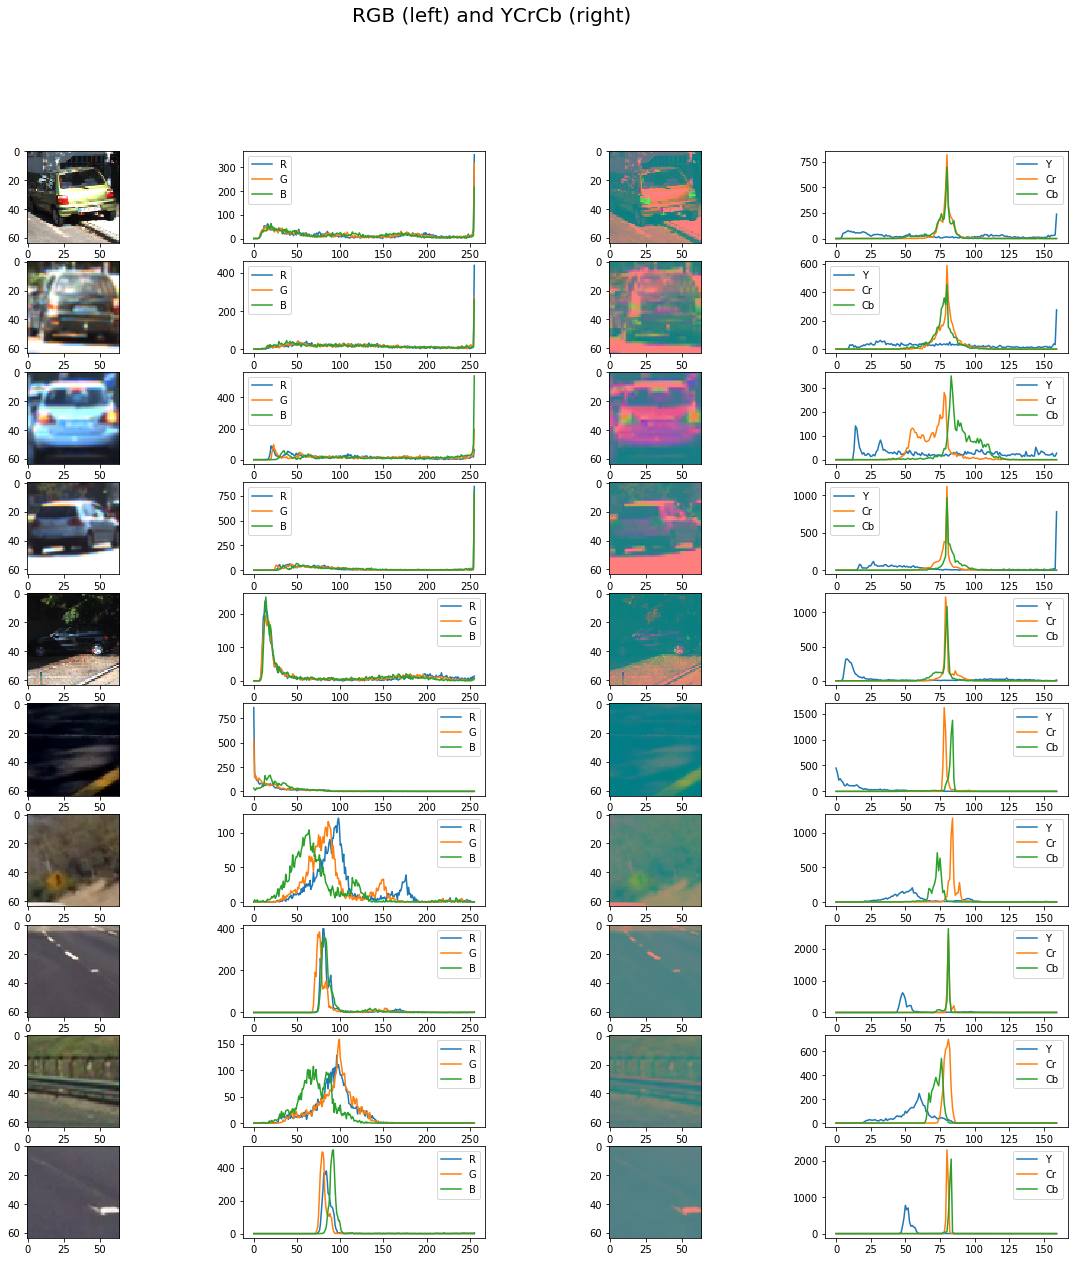

In [34]:
### Visualize color histogram features

plt.figure(figsize=(20,20))
plt.suptitle('RGB (left) and YCrCb (right)', fontsize=20)
for i, img in enumerate(test_images):
    #img = cv2.cvtColor(X[0], cv2.COLOR_RGB2HSV)
    hist_features = color_hist(img, nbins=256, feature_vector=False)
    plt.subplot(10,4,4*i+1)
    plt.imshow(img)
    plt.subplot(10,4,4*i+2)
    plt.plot(hist_features[0], label='R')
    plt.plot(hist_features[1], label='G')
    plt.plot(hist_features[2], label='B')
    plt.legend()
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    hist_features = color_hist(img, nbins=160, feature_vector=False)
    plt.subplot(10,4,4*i+3)
    plt.imshow(img)
    plt.subplot(10,4,4*i+4)
    plt.plot(hist_features[0], label='Y')
    plt.plot(hist_features[1], label='Cr')
    plt.plot(hist_features[2], label='Cb')
    plt.legend()
plt.savefig('./output_images/histogram_rbg_hsv.png', bbox_inches='tight')

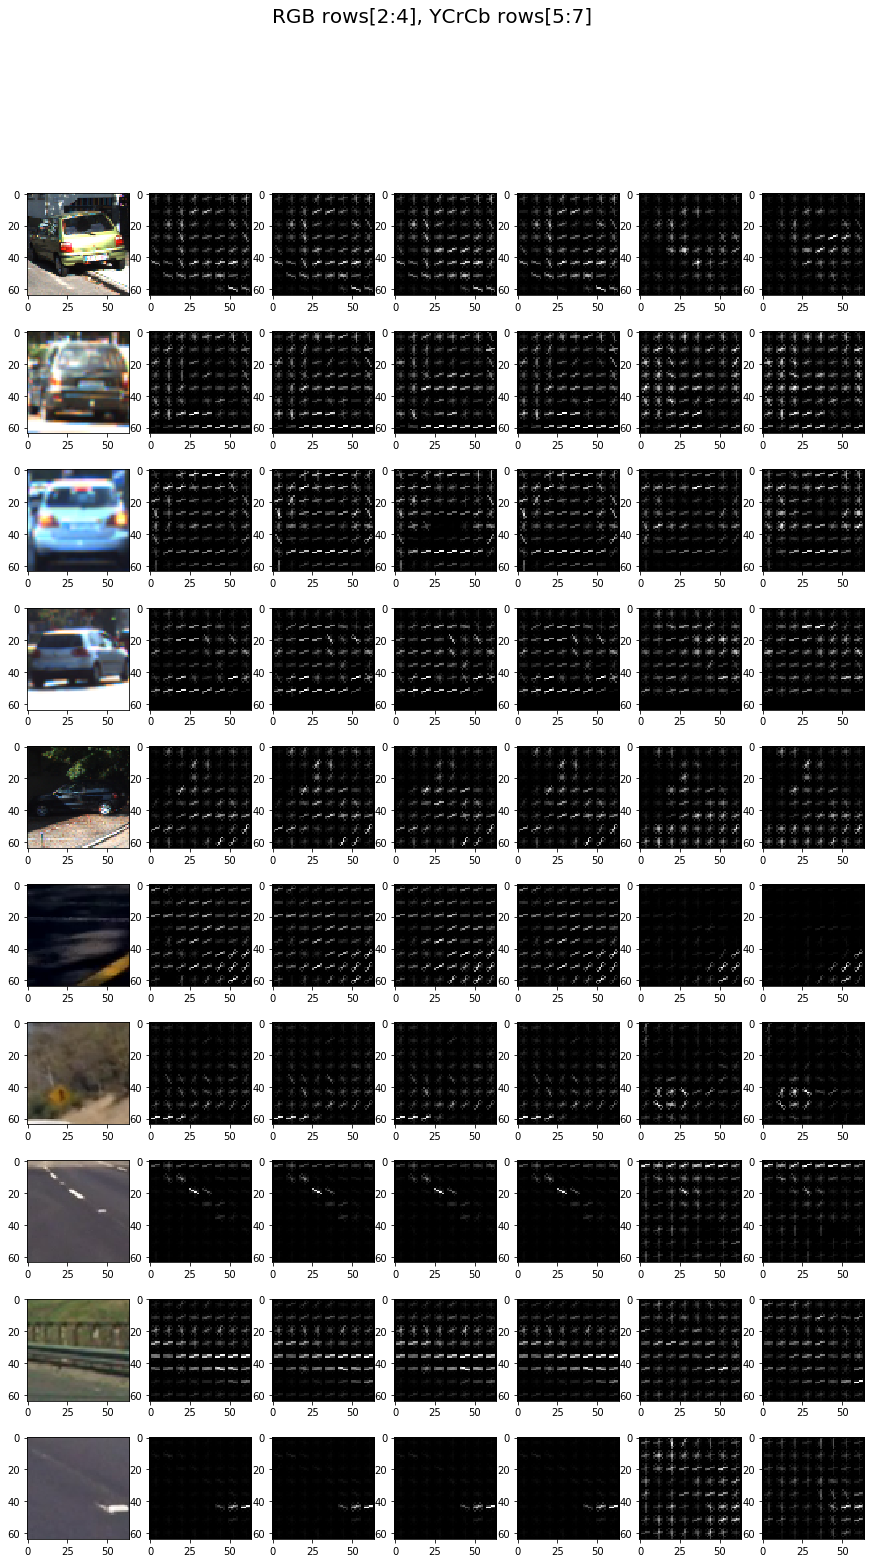

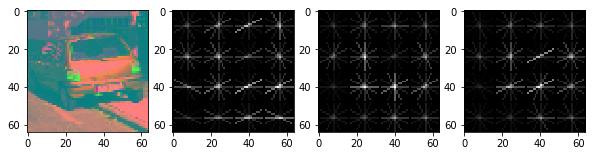

In [39]:
### Visualize HOG

plt.figure(figsize=(15,25))
plt.suptitle('RGB rows[2:4], YCrCb rows[5:7]', fontsize=20)
for i, img in enumerate(test_images):
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    _, hog_features1 = get_hog_features(img[:,:,0], orient=9, 
                    pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    _, hog_features2= get_hog_features(img[:,:,1], orient=9, 
                    pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    _, hog_features3 = get_hog_features(img[:,:,2], orient=9, 
                    pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    plt.subplot(10,7,7*i+1)
    plt.imshow(img)
    plt.subplot(10,7,7*i+2)
    plt.imshow(hog_features1, cmap='gray')
    plt.subplot(10,7,7*i+3)
    plt.imshow(hog_features2, cmap='gray')
    plt.subplot(10,7,7*i+4)
    plt.imshow(hog_features3, cmap='gray')
    
    _, hog_features1 = get_hog_features(feature_image[:,:,0], orient=9, 
                    pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    _, hog_features2= get_hog_features(feature_image[:,:,1], orient=9, 
                    pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    _, hog_features3 = get_hog_features(feature_image[:,:,2], orient=9, 
                    pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
    plt.subplot(10,7,7*i+5)
    plt.imshow(hog_features1, cmap='gray')
    plt.subplot(10,7,7*i+6)
    plt.imshow(hog_features2, cmap='gray')
    plt.subplot(10,7,7*i+7)
    plt.imshow(hog_features3, cmap='gray')
    
plt.savefig('./output_images/hog_features.png', bbox_inches='tight')


# Show final choice
plt.figure(figsize=(10,15))
img = test_images[0]
img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
_, hog_features1 = get_hog_features(img[:,:,0], orient=6, 
                pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=False)
_, hog_features2= get_hog_features(img[:,:,1], orient=6, 
                pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=False)
_, hog_features3 = get_hog_features(img[:,:,2], orient=6, 
                pix_per_cell=16, cell_per_block=2, vis=True, feature_vec=False)
plt.subplot(1,4,1)
plt.imshow(img)
plt.subplot(1,4,2)
plt.imshow(hog_features1, cmap='gray')
plt.subplot(1,4,3)
plt.imshow(hog_features2, cmap='gray')
plt.subplot(1,4,4)
plt.imshow(hog_features3, cmap='gray')
plt.savefig('./output_images/single_hog_features.png', bbox_inches='tight')

100%|██████████| 3552/3552 [00:09<00:00, 362.60it/s]


Train size:  14208
Test size:  3552
Length of feature vector:  744


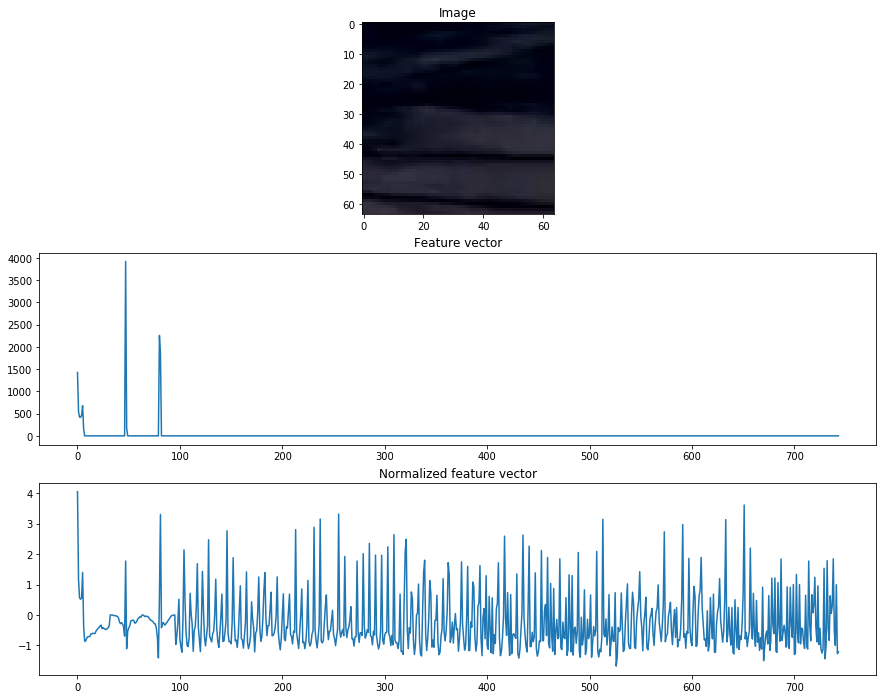

In [40]:
### Preprocess data

X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

orient = 6
pix_per_cell = 16
cell_per_block = 2
color_bins = 32

features_train = extract_features(X_train, cspace='YCrCb', orient=orient, pix_per_cell=pix_per_cell,
                                  cell_per_block=cell_per_block, color_bins=color_bins )
features_test = extract_features(X_test, cspace='YCrCb', orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block, color_bins=color_bins)

X_scaler = StandardScaler().fit(features_train)
scaled_features_train = X_scaler.transform(features_train)
scaled_features_test = X_scaler.transform(features_test)



### Visualize feature vector

print ('Train size: ', len(X_train))
print ('Test size: ', len(X_test))
print ('Length of feature vector: ', features_train[0].shape[0])

plt.figure(figsize=(15,12))
rand = randint(0,1000)
sub = plt.subplot(311)
sub.set_title('Image')
plt.imshow(X_train[rand])
sub = plt.subplot(312)
sub.set_title('Feature vector')
plt.plot(features_train[rand])
sub = plt.subplot(313)
sub.set_title('Normalized feature vector')
plt.plot(scaled_features_train[rand])
plt.savefig('./output_images/feature_vector.png', bbox_inches='tight')

In [41]:
### Train classifier
svc = LinearSVC().fit(scaled_features_train, y_train)
print('Test Accuracy: ', svc.score(scaled_features_test, y_test))

Test Accuracy:  0.985641891892


In [42]:
### Save classifier and scaler
with open('svc.p', 'wb') as pfile:
    pickle.dump(svc, pfile, pickle.HIGHEST_PROTOCOL)

with open('X_scaler.p', 'wb') as pfile:
    pickle.dump(X_scaler, pfile, pickle.HIGHEST_PROTOCOL)

In [3]:
### Load classifier
svc = []
X_scaler = []
with open('svc.p', mode='rb') as pfile:
    svc = pickle.load(pfile)
with open('X_scaler.p', mode='rb') as pfile:
    X_scaler = pickle.load(pfile)
#print('Test Accuracy of SVC = ', svc.score(scaled_features_test, y_test))

In [4]:
### Vehicle detection

# Define a single function that can extract features using hog sub-sampling and make predictions

ystart = 400
ystop = 656
scale = 1.0
orient = 6
pix_per_cell = 16
cell_per_block = 2
color_bins = 32



def find_cars(img, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=X_scaler, 
              orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
              color_bins=color_bins, draw_heatmap=True):
    
    draw_img = np.copy(img)
    draw_heat = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb) #YCrCb
    
    bboxes = []
    #if scale != 1:
    for factor in range(5):
        scale = factor/5. + 1.1
        imshape = ctrans_tosearch.shape
        ctrans_tosearch_sub = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch_sub[:,:,0]
        ch2 = ctrans_tosearch_sub[:,:,1]
        ch3 = ctrans_tosearch_sub[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ctrans_tosearch_sub.shape[1] // pix_per_cell)-1
        nyblocks = (ctrans_tosearch_sub.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        #img_gray = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2GRAY)
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

                #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch_sub[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                #spatial_features = bin_spatial(subimg)
                hist_features = color_hist(subimg, nbins=color_bins, feature_vector=False)

                # Create feature vector
                features = np.concatenate((hist_features[0], hist_features[1], hist_features[2], hog_feat1, hog_feat2, hog_feat3))

                # Scale features and make a prediction
                scl_feature = X_scaler.transform(features.reshape(1, -1))       
                test_prediction = svc.predict(scl_feature)
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
        
    if (draw_heatmap == False):
        return draw_img
    
    if (draw_heatmap == True):
        global heatmap
        # global img_counter
        heatmap = add_heat(heatmap, bboxes)
        #plt.figure()
        #plt.imshow(heatmap,cmap='hot')
        #output_file = './heatmaps/' + str(img_counter) + 'heatmap.png'
        #plt.savefig(output_file, bbox_inches='tight')
        
        heatmap = cool_down(heatmap,cool=2, high_clip=10)
        heatmap = apply_threshold(heatmap, 4)
        labels = label(heatmap)
        #plt.imshow(labels[0],cmap='gray')
        #output_file = './heatmaps/' + str(img_counter) + 'labels.png'
        #plt.savefig(output_file, bbox_inches='tight')
        
        draw_heat = draw_labeled_bboxes(draw_heat, labels)
        #plt.imshow(draw_heat)
        #output_file = './heatmaps/' + str(img_counter) + 'draw_heat.png'
        #plt.savefig(output_file, bbox_inches='tight')
        
        #img_counter += 1
        
        return draw_heat
    
def cool_down(heatmap, cool, high_clip):
    heatmap -= cool
    heatmap = np.clip(heatmap,0,high_clip)
    return heatmap

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Data type with plt:  uint8
Min:  0 Max:  255
Data type with cv2:  uint8
Min:  0 Max:  255
Data type with mpimg:  uint8
Min:  0 Max:  255


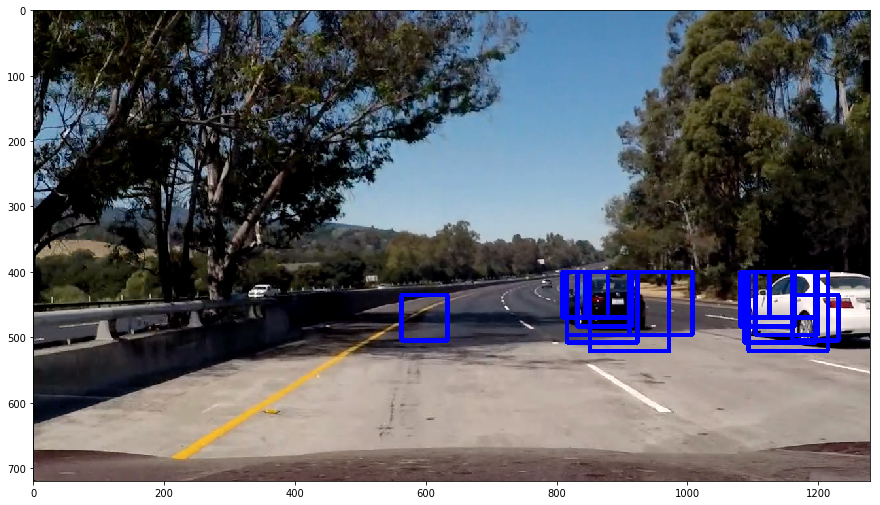

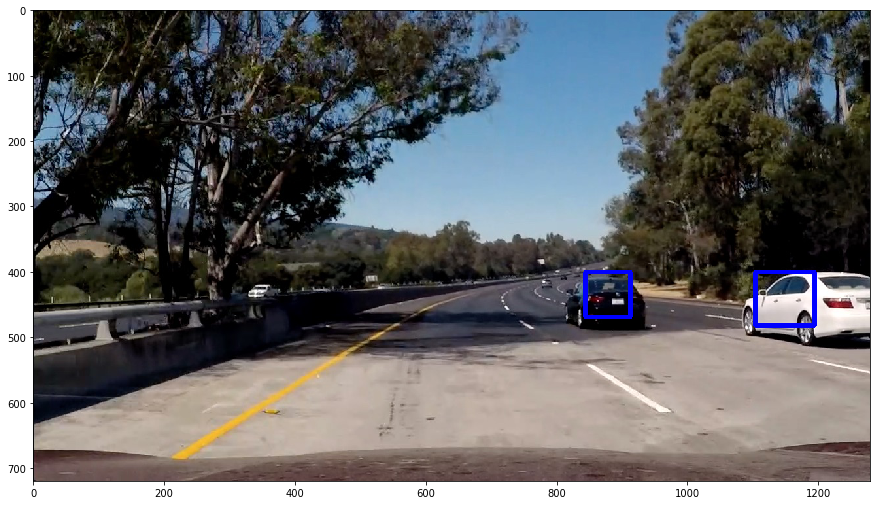

In [59]:
### Vehicle detection on test_images

test_images_scene = glob.glob('./test_images/*.jpg')
img = plt.imread(test_images_scene[2])

img_plt = plt.imread(test_images_scene[5])
img_cv2 = cv2.imread(test_images_scene[5])
img_mpimg = mpimg.imread(test_images_scene[5])
print ('Data type with plt: ', img_plt.dtype)
print ('Min: ', np.min(img_plt), 'Max: ', np.max(img_plt))
print ('Data type with cv2: ', img_cv2.dtype)
print ('Min: ', np.min(img_cv2), 'Max: ', np.max(img_cv2))
print ('Data type with mpimg: ', img_mpimg.dtype)
print ('Min: ', np.min(img_mpimg), 'Max: ', np.max(img_mpimg))


# Show raw detection
out_img = find_cars(img, draw_heatmap=False)
plt.figure(figsize=(15,10))
plt.imshow(out_img)
plt.savefig('./output_images/raw_detection1.png', bbox_inches='tight')

# Apply thresholding
heatmap = np.zeros_like(img)
out_heat = find_cars(img, draw_heatmap=True)
plt.figure(figsize=(15,10))
plt.imshow(out_heat)
plt.savefig('./output_images/heat_thresholding.png', bbox_inches='tight')

In [7]:
input_video = 'project_video.mp4'
output_video = 'vehicle_detection.mp4'
input_clip = VideoFileClip(input_video,audio=False)
#start_time = time.clock()
video_size = input_clip.size

# Create global heatmap for tracking over mutliple frames
heatmap = np.zeros((video_size[1],video_size[0]))
img_counter = 0

output_clip = input_clip.fl_image(find_cars)
output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video vehicle_detection.mp4
[MoviePy] Writing video vehicle_detection.mp4


100%|█████████▉| 1260/1261 [14:28<00:00,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection.mp4 

